# Réseau de neurones pour la classification avec Pytorch

## Les imports

In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import torch
from torch import nn

from my_helper_functions import accuracy_fn, plot_decision_boundary


## Constantes

In [2]:
RANDOM_STATE = 20
NBR_INPUTS = 2
NBR_OUTPUTS = 4

## Create dataset

In [3]:
x, y = make_blobs(n_samples=1000, n_features=NBR_INPUTS, centers=NBR_OUTPUTS, cluster_std=1.5, random_state=RANDOM_STATE)
print(f"x shape : {x.shape}")
print(f"y shape : {y.shape}")

x shape : (1000, 2)
y shape : (1000,)


In [4]:
x[:5], y[:5]

(array([[ 1.15232915,  6.10745464],
        [-8.69380102,  5.55720101],
        [ 0.23024192,  8.66269151],
        [ 8.18223886,  4.97312766],
        [-7.7675401 ,  2.68558928]]),
 array([0, 2, 0, 1, 2]))

In [5]:
x.dtype, y.dtype

(dtype('float64'), dtype('int32'))

## Split data to train and test data

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)
print("Train :")
print(f"x_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")
print("Test :")
print(f"x_test shape : {x_test.shape}")
print(f"y_test shape : {y_test.shape}")

Train :
x_train shape : (800, 2)
y_train shape : (800,)
Test :
x_test shape : (200, 2)
y_test shape : (200,)


## Visualise data

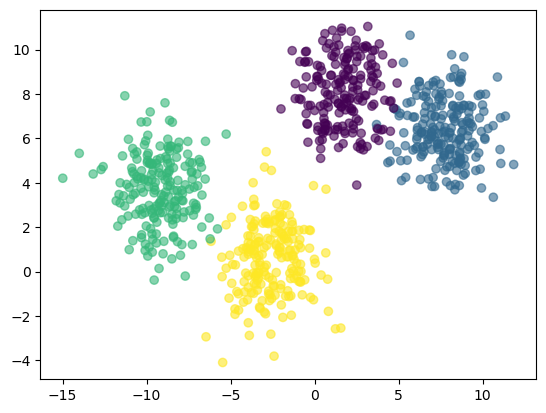

In [7]:
plt.figure()
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, alpha=0.6)
plt.show()

## Adapt data to PyTorch

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
type(x_train)

numpy.ndarray

In [10]:
# Train
x_train = torch.from_numpy(x_train).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.long).to(device)
# Test
x_test = torch.from_numpy(x_test).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.long).to(device)
x_train[:5], y_test[:5]

(tensor([[ -3.3588,  -0.3135],
         [-13.1777,   4.3974],
         [ -7.8273,   2.4314],
         [ -8.6589,   2.9140],
         [ -8.6895,   2.4157]], device='cuda:0'),
 tensor([2, 0, 2, 3, 3], device='cuda:0'))

In [11]:
type(x_train), type(y_train)

(torch.Tensor, torch.Tensor)

## Create Model

In [12]:
class MultiClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(NBR_INPUTS, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, NBR_OUTPUTS)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [13]:
model = MultiClassificationModel().to(device)
model

MultiClassificationModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

## Loss and Optimizer

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() ,lr=0.01)

## Train

In [15]:
logits = model(x_train)
logits[:5]

tensor([[-0.2244,  0.3104,  0.0454,  0.0850],
        [ 0.0565,  0.7773, -0.6193,  0.7195],
        [-0.0606,  0.5418, -0.3011,  0.4150],
        [-0.0154,  0.5747, -0.3782,  0.4805],
        [-0.0734,  0.5843, -0.3166,  0.4457]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [16]:
epochs = 150
train_loss_array = []
train_accuracy_array = []
test_loss_array = []
test_accuracy_array = []
softmax = nn.Softmax(dim=1)

for epoch in range(epochs):
    model.train()
    train_logits = model(x_train)
    # Calculate loss
    train_loss = loss_fn(train_logits, y_train)
    train_loss_array.append(train_loss.detach().cpu().numpy())
    # Calculate accuracy
    train_log_proba = softmax(train_logits)
    y_train_pred = torch.argmax(train_log_proba, dim=1)
    train_accuracy = accuracy_fn(y_pred=y_train_pred, y_true=y_train)
    train_accuracy_array.append(train_accuracy)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(x_test)
        # Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_loss_array.append(test_loss.detach().cpu().numpy())
        # Calculate accuracy
        test_log_proba = softmax(test_logits)
        y_test_pred = torch.argmax(test_log_proba, dim=1)
        test_accuracy = accuracy_fn(y_pred=y_test_pred, y_true=y_test)
        test_accuracy_array.append(test_accuracy)

    if epoch % 10 == 0:
        print(f"epoch {epoch} : train loss -> {train_loss} - train accuracy -> {train_accuracy} % | test loss -> {test_loss} - test accuracy -> {test_accuracy} %")

epoch 0 : train loss -> 1.5003859996795654 - train accuracy -> 16.125 % | test loss -> 1.3981796503067017 - test accuracy -> 38.0 %
epoch 10 : train loss -> 0.8400394320487976 - train accuracy -> 70.0 % | test loss -> 0.736741304397583 - test accuracy -> 72.5 %
epoch 20 : train loss -> 0.4667561650276184 - train accuracy -> 84.75 % | test loss -> 0.4346952736377716 - test accuracy -> 87.0 %
epoch 30 : train loss -> 0.2878694236278534 - train accuracy -> 86.25 % | test loss -> 0.2756239175796509 - test accuracy -> 91.0 %
epoch 40 : train loss -> 0.21804285049438477 - train accuracy -> 93.375 % | test loss -> 0.21626178920269012 - test accuracy -> 94.0 %
epoch 50 : train loss -> 0.15906135737895966 - train accuracy -> 97.75 % | test loss -> 0.1606692522764206 - test accuracy -> 98.0 %
epoch 60 : train loss -> 0.10944990068674088 - train accuracy -> 98.75 % | test loss -> 0.11634380370378494 - test accuracy -> 99.0 %
epoch 70 : train loss -> 0.07538599520921707 - train accuracy -> 98.75 %

In [17]:
print(f"epoch {epoch} : train loss -> {train_loss} - train accuracy -> {train_accuracy} % | test loss -> {test_loss} - test accuracy -> {test_accuracy} %")

epoch 149 : train loss -> 0.02408904768526554 - train accuracy -> 99.25 % | test loss -> 0.052723538130521774 - test accuracy -> 98.5 %


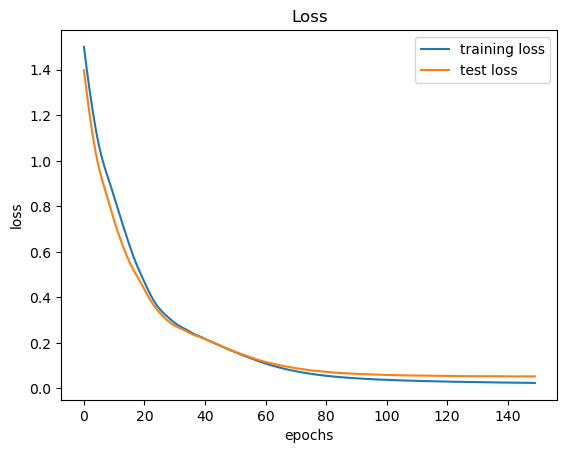

In [18]:
plt.figure()
plt.title("Loss")
plt.plot(range(epochs), train_loss_array, label="training loss")
plt.plot(range(epochs), test_loss_array, label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()


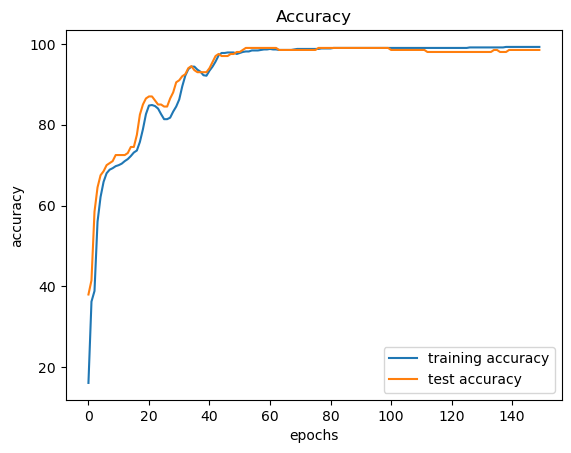

In [19]:
plt.figure()
plt.title("Accuracy")
plt.plot(range(epochs), train_accuracy_array, label="training accuracy")
plt.plot(range(epochs), test_accuracy_array, label="test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

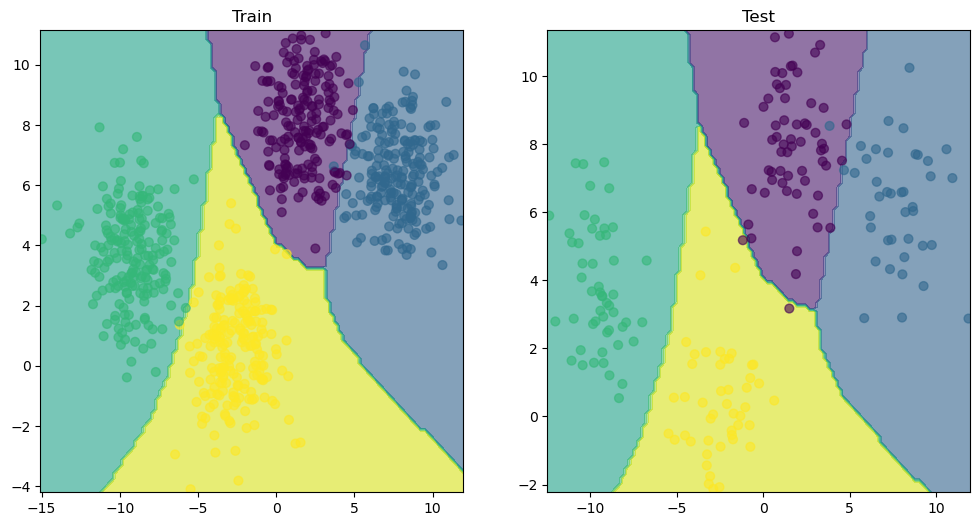

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)